# Read NI DATA And Map to Allen Space

## Setup

### Imports

In [21]:
import os

import numpy as np
from dotenv import load_dotenv
import pprint
import nrrd
import matplotlib.pyplot as plt

from src.core.utils import fs

from src.flatmap.utils.read_ni_output import get_marker_points_from_xml

### Setup Data Paths

In [15]:
# Load environment variables from .env file
if load_dotenv() is False:
    print("Failed to load .env file")

EXPERIMENT_DATA_DIR = os.getenv("CASE_FILE_DATA_DIR")
if EXPERIMENT_DATA_DIR is None:
    print("Failed to load CASE_FILE_DATA_DIR from .env file")

example_case_file_dir = os.path.join(EXPERIMENT_DATA_DIR, "working")
case_files = fs.find_in_dir_with_ext(example_case_file_dir, ".xml")
if len(case_files) == 0:
    print("No case files found in directory")

CASE_FILE_PATH = case_files[0]

ALLEN_DATA_DIR = os.getenv("ALLEN_ATLAS_FILES")
CORONAL_DATA_DIR = os.getenv("MBF_ALLEN_CORONAL_FILES")

if ALLEN_DATA_DIR is None:
    print("Failed to load ALLEN_ATLAS_FILES from .env file")

if CORONAL_DATA_DIR is None:
    print("Failed to load MBF_ALLEN_CORONAL_FILES from .env file")

CORONAL_ANNOTATION_PATH = os.path.join(CORONAL_DATA_DIR, "AllenCoronal_10um_anatomy.nrrd")
ALLEN_ANNOTATION_PATH = os.path.join(ALLEN_DATA_DIR, "annotation_10.nrrd")

CORONAL_AVERAGE_PATH = os.path.join(CORONAL_DATA_DIR, "AllenCoronal_25um.nrrd")
ALLEN_AVERAGE_PATH = os.path.join(ALLEN_DATA_DIR, "average_template_25.nrrd")

if os.path.exists(CORONAL_ANNOTATION_PATH) is False:
    print(f"Failed to find coronal annotation file: {CORONAL_ANNOTATION_PATH}")

if os.path.exists(ALLEN_ANNOTATION_PATH) is False:\
    print(f"Failed to find allen annotation file: {ALLEN_ANNOTATION_PATH}")

In [5]:
print(f"Case file path: {CASE_FILE_PATH}")
print(f"Coronal annotation path: {CORONAL_ANNOTATION_PATH}")
print(f"Allen annotation path: {ALLEN_ANNOTATION_PATH}")

Case file path: D:/data/neuro/flatmap/experiments\working\2000_ChAT_rabies 6cases Cortex.xml
Coronal annotation path: D:/data/neuro/Allen/Atlases/Allen2017\AllenCoronal_10um_anatomy.nrrd
Allen annotation path: D:/data/neuro/Allen\annotation_10.nrrd


In [24]:
# Read annotated volumes
coronal_volume, coronal_avg_header = nrrd.read(CORONAL_AVERAGE_PATH)
coronal_annotation_volume, coronal__annot_header = nrrd.read(CORONAL_ANNOTATION_PATH)

allen_annotation_volume, allen_annot_header = nrrd.read(ALLEN_ANNOTATION_PATH)
allen_volume, allen_avg_header = nrrd.read(ALLEN_AVERAGE_PATH)

print(f"Coronal data shape: {coronal_annotation_volume.shape}")
print(f"Allen data shape: {allen_annotation_volume.shape}")

# print("Coronal data type: ", coronal_header)
# print("Allen data type: ", allen_header)

Coronal data shape: (1140, 800, 1320)
Allen data shape: (1320, 800, 1140)


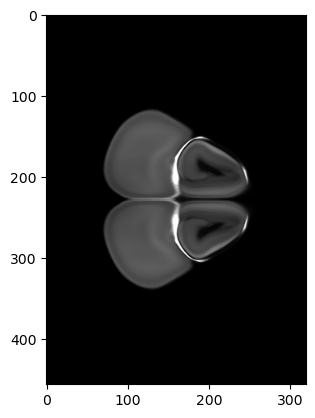

In [18]:
plt.imshow(coronal_volume[:, :, 100], cmap="gray")

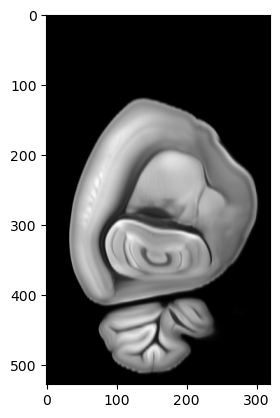

In [25]:
coronal_copy = coronal_volume.copy()
coronal_copy = np.swapaxes(coronal_copy, 0, 2)
plt.imshow(coronal_copy[:, :, -100], cmap="gray")

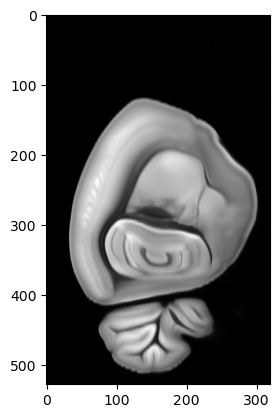

In [26]:
plt.imshow(allen_volume[:, :, 100], cmap="gray")

In [27]:
marker_dict = get_marker_points_from_xml(CASE_FILE_PATH)

In [1]:
markers = marker_dict["KC04_lat"]


NameError: name 'marker_dict' is not defined

In [30]:
factor_values = (-10, -10, 10)
# points_vals = markers.copy()

mbf_point_vals = markers.copy()
mbf_point_vals = np.floor(mbf_point_vals / factor_values).astype(int)

points_vals = mbf_point_vals.copy()
points_vals[:, 0] = mbf_point_vals[:, 2]
points_vals[:, 1] = mbf_point_vals[:, 1]
points_vals[:, 2] = mbf_point_vals[:, 0]

In [31]:
structure_counts_mbf = {}
structure_counts_allen = {}

# coronal_annotation_volume, coronal__annot_header = nrrd.read(CORONAL_ANNOTATION_PATH)
# allen_annotation_volume, allen_annot_header = nrrd.read(ALLEN_ANNOTATION_PATH)

for point in mbf_point_vals:
    x, y, z = point
    structure_id_mbf = coronal_annotation_volume[x, y, z]
    structure_id_allen = allen_annotation_volume[z, y, x]
    if structure_id_mbf in structure_counts_mbf:
        structure_counts_mbf[structure_id_mbf] += 1
    else:
        structure_counts_mbf[structure_id_mbf] = 1

    if structure_id_allen in structure_counts_allen:
        structure_counts_allen[structure_id_allen] += 1
    else:
        structure_counts_allen[structure_id_allen] = 1